In [1]:
import torch
import chess.pgn
import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, hyperparams):
        super(Encoder, self).__init__()

        channels = hyperparams["position_channels"]
        n_embed = hyperparams["n_embed"]
        filters = hyperparams["filters"]
        fc_size = hyperparams["fc_size"]
        
        self.conv1 = nn.Conv2d(channels, filters, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(filters, filters * 2, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(filters * 2, filters * 4, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(filters * 4 * 1 * 1, fc_size)
        self.fc2 = nn.Linear(fc_size, n_embed)  # Compressed representation

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))  
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, hyperparams):        
        super(Decoder, self).__init__()

        channels = hyperparams["position_channels"]
        n_embed = hyperparams["n_embed"]
        filters = hyperparams["filters"]
        fc_size = hyperparams["fc_size"]

        
        self.fc1 = nn.Linear(n_embed, fc_size)
        self.fc2 = nn.Linear(fc_size, filters * 4 * 1 * 1)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(filters * 4 , 1, 1))
        self.deconv1 = nn.ConvTranspose2d(filters * 4, filters * 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(filters * 2, filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(filters, channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.unflatten(x)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        return x

class PositionAutoEncoder(nn.Module):
    def __init__(self, hyperparams):
        super(PositionAutoEncoder, self).__init__()
        self.encoder = Encoder(hyperparams)
        self.decoder = Decoder(hyperparams)

    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

    @torch.no_grad()
    def embed(self, x):
        code = self.encoder(x)
        return code

In [4]:
from torch.utils.data import Dataset, DataLoader


class PositionDataset(Dataset):
  def __init__(self, tensors):
        self.tensors = tensors

  def __len__(self):
      return len(self.tensors)

  def __getitem__(self, idx):
        return self.tensors[idx]

In [6]:
device = "mps" if torch.backends.mps.is_available() else "cuda"
device = torch.device(device)

chkp = torch.load("models/v0.pt")
emb_model = PositionAutoEncoder(chkp["hyperparameters"]).to(device)
emb_model.eval()
emb_model.load_state_dict(chkp["model"])

<All keys matched successfully>

In [7]:
piece_to_idx = {'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
                'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11}

def pos_to_tensor(fen, device="mps"):
    parts = fen.split(" ")
    wtm = parts[1] == "w"
    castling_rights = parts[2]

    board = chess.Board(fen)
    tensor = torch.zeros(15, 8, 8, device=device)

    for row in range(8): 
        for col in range(8):
            sqr = chess.square(col, 7 - row)
            piece = board.piece_at(sqr)
            if piece is not None:
                p = piece.symbol()
                idx = piece_to_idx[p]
                tensor[idx, row, col] = 1 if p.isupper() else -1
                  
    # Encode castling rights
    if 'K' in castling_rights:
        tensor[12, 0, 0] = 1
    if 'Q' in castling_rights:
        tensor[12, 0, 7] = 1
    if 'k' in castling_rights:
        tensor[13, 7, 0] = -1  
    if 'q' in castling_rights:
        tensor[13, 7, 7] = -1
          
    # Encode side to move
    tensor[14] = 1 if wtm else -1
      
    return tensor

In [9]:
import pandas as pd

df = pd.read_csv("chess-evals/random_evals.csv")


num_positions = 1000
# pick the first thousand positions and the first thousand evaluations
positions = df["FEN"].values[:num_positions]
evals = df["Evaluation"].values[:num_positions]

# convert the positions to tensors
pos_tensors = [pos_to_tensor(pos, device) for pos in positions]

# embed the positions
embeddings = [emb_model.embed(pos.unsqueeze(0)) for pos in pos_tensors]

In [10]:
# reshape embeddings from (1, 128) to (128,)
embeddings = [emb.squeeze(0) for emb in embeddings]
embeddings = torch.stack(embeddings)

In [11]:
# processing evals
# if it is checkmate #, then it is +/- 512000

def eval_to_score(evaluation: str) -> int:
    if evaluation[0] == "#":
        return 512000 if evaluation[1] == "+" else -512000
    return int(evaluation)

evals = [eval_to_score(eval) for eval in evals]

print(evals)

[-459, -125, 198, -155, 209, -101, -105, -136, -1262, -117, 104, 108, 194, 93, -71, 217, 163, 176, -1248, -128, -55, 128, -135, -161, -138, -148, -55, -123, -129, -151, -104, 141, 378, -159, 363, -132, -139, 378, -96, -155, 359, 454, -182, 409, 490, 374, 386, 367, 390, -252, 378, 359, -435, 344, 363, -60, -17, 463, 184, -230, -109, 412, -51, -138, -42, -104, -58, -63, -40, -71, -27, 27, -5, -45, 0, 214, 58, -59, -48, 0, -153, 574, 417, 186, 265, -40, -119, -84, -117, 156, 263, 165, 594, 271, 567, 144, -50, 234, -459, 157, -21, 200, 273, -47, 117, 190, -20, 172, 230, -41, 148, -301, -90, -136, -28, -70, -50, -83, -471, -78, -74, -51, -463, -109, 43, -217, -75, -59, -1230, -21, -67, -76, -71, 12, -66, 444, -32, -34, 436, -190, 497, 528, -132, -175, 474, 569, 513, 815, 472, 625, 270, 564, 428, 372, 438, 501, 205, 477, 367, 448, 563, 418, 445, 475, 572, 509, -1262, -148, 575, 424, 501, -138, -84, -1290, -109, -413, -80, -238, 557, -148, -28, -48, -131, -112, -467, -98, -86, -136, -107, -98

In [72]:
print(embeddings[0].shape)
print(embeddings.shape)


torch.Size([128])
torch.Size([16384, 128])


In [12]:
evals = torch.tensor(evals, device=device)

In [13]:
# run pca on the embeddings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(embeddings.cpu().numpy())

embeddings_pca = pca.transform(embeddings.cpu().numpy())

# plot the embeddings, and make it so that when you hover over a scatter point it shows the evaluation
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=evals.cpu().numpy())
plt.colorbar()
plt.show()



ModuleNotFoundError: No module named 'sklearn'

torch.Size([16384])


ValueError: x and y must be the same size

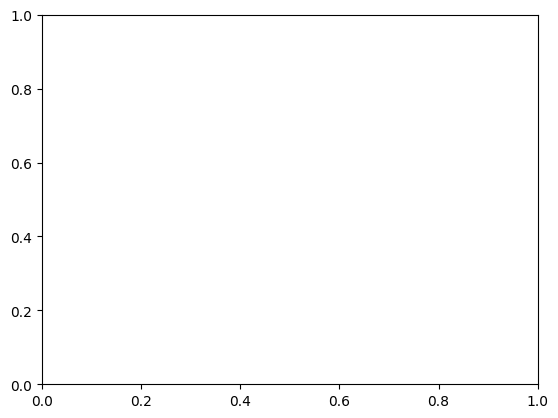

In [93]:
# now we want to predict the evaluations
B1 = B.detach().clone()
B1.requires_grad = False
B1.cpu()

# take another set of positions and plot the evaluations
positions = df["FEN"].values[16384:16384 + 100]
new_evals = df["Evaluation"].values[16384:16384 + 100]

# convert the positions to tensors
new_pos_tensors = [pos_to_tensor(pos, device) for pos in positions]

# embed the positions
new_embeddings = [emb_model.embed(pos.unsqueeze(0)) for pos in pos_tensors]

# reshape embeddings from (1, 128) to (128,)
new_embeddings = [emb.squeeze(0) for emb in embeddings]
new_embeddings = torch.stack(new_embeddings).cpu()

# processing evals
new_evals = [eval_to_score(new_eval) for new_eval in new_evals]
new_evals = torch.tensor(new_evals, device=device).float().cpu()

# get devices
B1 = B1.cpu()
new_evals = new_evals.cpu()
new_embeddings = new_embeddings.cpu()

predictions = [torch.dot(B1, emb) for emb in new_embeddings]
predictions = torch.stack(predictions)

print(predictions.shape)

import matplotlib.pyplot as plt

plt.scatter(new_evals, predictions)
plt.xlabel("True Evaluation")
plt.ylabel("Predicted Evaluation")
plt.title("True vs Predicted Evaluation")
plt.show()